In [2]:
import zipfile
import os

# 압축 파일 경로 및 해제할 폴더 경로 설정
zip_file_path = '/content/최종.zip'
extract_dir = '/content/uploadfolder'  # 압축 해제할 폴더 경로

# 압축 파일이 존재하는지 확인
if os.path.exists(zip_file_path):
    print(f"'{zip_file_path}' 파일을 찾았습니다.")

    # 압축을 풀 폴더가 없으면 생성
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
        print(f"'{extract_dir}' 폴더를 생성했습니다.")

    # zipfile 라이브러리를 사용하여 압축 해제
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
        print(f"'{zip_file_path}' 압축을 '{extract_dir}'에 성공적으로 해제했습니다.")
else:
    print(f"'{zip_file_path}' 파일을 찾을 수 없습니다. 경로를 확인하세요.")

'/content/최종.zip' 파일을 찾았습니다.
'/content/uploadfolder' 폴더를 생성했습니다.
'/content/최종.zip' 압축을 '/content/uploadfolder'에 성공적으로 해제했습니다.


In [6]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from collections import Counter

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []

        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# 경로 및 배치 크기 설정
base_dir = '/content/uploadfolder'  # 베이스 경로
batch_size = 16

# 사용할 데이터 선택 (오른볼, 왼볼, 이마 중 하나 선택)
data_dir = os.path.join(base_dir, '오른볼 최종')  # 예시: '오른볼 최종' 사용

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # 더 큰 회전 각도
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(os.path.join(data_dir, '오른볼train'), transform=transform)
valid_dataset = CustomDataset(os.path.join(data_dir, '오른볼valid'), transform=transform)

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# 각 샘플의 가중치를 리스트로 변환
sample_weights = [class_weights[label] for _, label in train_dataset]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 resnext50_32x4d 모델 사용
from torchvision.models import ResNeXt50_32X4D_Weights

weights = ResNeXt50_32X4D_Weights.DEFAULT
model = models.resnext50_32x4d(weights=weights)

# 모든 레이어 학습 가능하도록 설정 (전이 학습 제외)
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정 (드롭아웃 비율 0.3으로 설정)
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # Dropout 비율을 0.3으로 조정
    nn.Linear(model.fc.in_features, len(train_dataset.classes))
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping 설정
best_accuracy = 0
patience = 5  # 개선되지 않는 에포크를 허용하는 최대 수
counter = 0

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.0001로 감소)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# 학습률 스케줄러 추가 (학습률 점진적 감소, gamma=0.5, step_size=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 과정 (TQDM으로 진행 상황 시각화, 에포크 30)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}%")

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 평가
    model.eval()
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid
    print(f'Validation Accuracy: {valid_accuracy}%')

    # Early Stopping 기준
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        counter = 0  # 성능 개선 시 카운터 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping 적용")
            break


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 58.2MB/s]
Epoch 1/30: 100%|██████████| 116/116 [00:42<00:00,  2.76it/s, loss=1.03]


Epoch 1/30, Loss: 1.034431876293544, Train Accuracy: 45.42025862068966%
Validation Accuracy: 43.421052631578945%


Epoch 2/30: 100%|██████████| 116/116 [00:45<00:00,  2.56it/s, loss=0.875]


Epoch 2/30, Loss: 0.8753821983419615, Train Accuracy: 59.05172413793103%
Validation Accuracy: 41.666666666666664%


Epoch 3/30: 100%|██████████| 116/116 [00:39<00:00,  2.96it/s, loss=0.705]


Epoch 3/30, Loss: 0.7050945630361294, Train Accuracy: 67.94181034482759%
Validation Accuracy: 53.07017543859649%


Epoch 4/30: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s, loss=0.547]


Epoch 4/30, Loss: 0.5472218129655411, Train Accuracy: 76.13146551724138%
Validation Accuracy: 53.50877192982456%


Epoch 5/30: 100%|██████████| 116/116 [00:43<00:00,  2.70it/s, loss=0.468]


Epoch 5/30, Loss: 0.4680880295305416, Train Accuracy: 79.79525862068965%
Validation Accuracy: 59.21052631578947%


Epoch 6/30: 100%|██████████| 116/116 [00:41<00:00,  2.79it/s, loss=0.366]


Epoch 6/30, Loss: 0.3660800177282814, Train Accuracy: 86.36853448275862%
Validation Accuracy: 62.280701754385966%


Epoch 7/30: 100%|██████████| 116/116 [00:42<00:00,  2.73it/s, loss=0.263]


Epoch 7/30, Loss: 0.2632991810297144, Train Accuracy: 89.70905172413794%
Validation Accuracy: 57.01754385964912%


Epoch 8/30: 100%|██████████| 116/116 [00:41<00:00,  2.78it/s, loss=0.229]


Epoch 8/30, Loss: 0.22921756972912058, Train Accuracy: 90.89439655172414%
Validation Accuracy: 58.771929824561404%


Epoch 9/30: 100%|██████████| 116/116 [00:41<00:00,  2.76it/s, loss=0.228]


Epoch 9/30, Loss: 0.22832843972819633, Train Accuracy: 91.21767241379311%
Validation Accuracy: 62.719298245614034%


Epoch 10/30: 100%|██████████| 116/116 [00:42<00:00,  2.72it/s, loss=0.211]


Epoch 10/30, Loss: 0.21135532441709576, Train Accuracy: 91.64870689655173%
Validation Accuracy: 62.280701754385966%


Epoch 11/30: 100%|██████████| 116/116 [00:41<00:00,  2.77it/s, loss=0.113]


Epoch 11/30, Loss: 0.1133986260452918, Train Accuracy: 96.39008620689656%
Validation Accuracy: 68.42105263157895%


Epoch 12/30: 100%|██████████| 116/116 [00:41<00:00,  2.76it/s, loss=0.0842]


Epoch 12/30, Loss: 0.08420853706173084, Train Accuracy: 97.19827586206897%
Validation Accuracy: 63.59649122807018%


Epoch 13/30: 100%|██████████| 116/116 [00:41<00:00,  2.81it/s, loss=0.0971]


Epoch 13/30, Loss: 0.09714051817768607, Train Accuracy: 96.76724137931035%
Validation Accuracy: 64.47368421052632%


Epoch 14/30: 100%|██████████| 116/116 [00:41<00:00,  2.83it/s, loss=0.0691]


Epoch 14/30, Loss: 0.06908021351836365, Train Accuracy: 97.84482758620689%
Validation Accuracy: 68.42105263157895%


Epoch 15/30: 100%|██████████| 116/116 [00:41<00:00,  2.78it/s, loss=0.0609]


Epoch 15/30, Loss: 0.06086285017101608, Train Accuracy: 97.89870689655173%
Validation Accuracy: 62.719298245614034%


Epoch 16/30: 100%|██████████| 116/116 [00:41<00:00,  2.78it/s, loss=0.0549]


Epoch 16/30, Loss: 0.054877640119480806, Train Accuracy: 98.38362068965517%
Validation Accuracy: 67.98245614035088%
Early stopping 적용


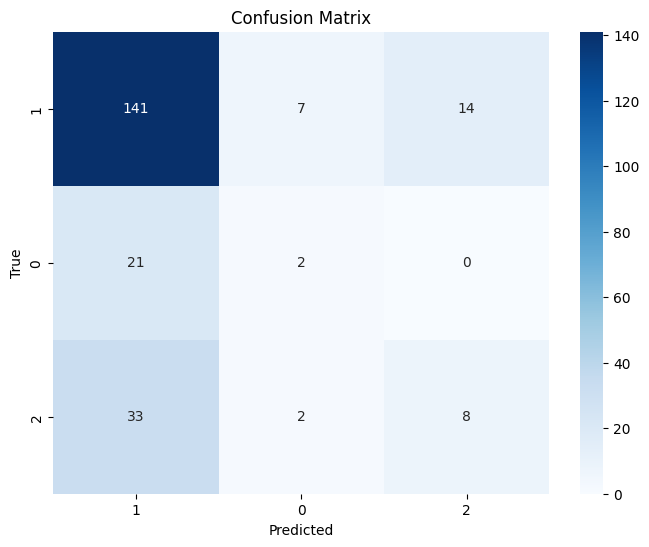

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 혼동 행렬을 계산하고 시각화하는 함수
def plot_confusion_matrix(model, valid_loader, classes):
    model.eval()  # 모델을 평가 모드로 설정
    all_preds = []
    all_labels = []

    # 검증 데이터셋에 대한 예측값 수집
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())  # 예측값을 리스트에 추가
            all_labels.extend(labels.cpu().numpy())  # 실제 라벨을 리스트에 추가

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬을 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 클래스 목록을 제공해야 함 (ex. ['class1', 'class2', 'class3', ...])
classes = train_dataset.classes  # train_dataset에서 클래스 이름 가져오기

# 혼동 행렬 출력
plot_confusion_matrix(model, valid_loader, classes)

## 튜닝

In [5]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from collections import Counter

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []

        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# 경로 및 배치 크기 설정
base_dir = '/content/uploadfolder'  # 베이스 경로
batch_size = 16

# 사용할 데이터 선택 (오른볼, 왼볼, 이마 중 하나 선택)
data_dir = os.path.join(base_dir, '오른볼 최종')  # 예시: '오른볼 최종' 사용

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # 더 큰 회전 각도
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(os.path.join(data_dir, '오른볼train'), transform=transform)
valid_dataset = CustomDataset(os.path.join(data_dir, '오른볼valid'), transform=transform)

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# 각 샘플의 가중치를 리스트로 변환
sample_weights = [class_weights[label] for _, label in train_dataset]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 resnext50_32x4d 모델 사용
from torchvision.models import ResNeXt50_32X4D_Weights

weights = ResNeXt50_32X4D_Weights.DEFAULT
model = models.resnext50_32x4d(weights=weights)

# 모든 레이어 학습 가능하도록 설정 (전이 학습 제외)
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정 (드롭아웃 비율 0.3으로 설정)
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # Dropout 비율을 0.3으로 조정
    nn.Linear(model.fc.in_features, len(train_dataset.classes))
)

model.to(device)  # 모델을 GPU/CPU에 올리기

# best_accuracy 초기화
best_accuracy = 0.0  # 가장 높은 검증 정확도를 기록할 변수

# Early Stopping 설정
patience = 5  # 개선되지 않는 에포크를 허용하는 최대 수
counter = 0

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.0001로 감소)
criterion = torch.nn.CrossEntropyLoss()  # 가중치 적용을 원한다면 weight 인자를 추가
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# 학습률 스케줄러 추가 (학습률 점진적 감소, gamma=0.5, step_size=10)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 학습 과정 (TQDM으로 진행 상황 시각화, 에포크 30)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}%")

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 평가
    model.eval()
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid
    print(f'Validation Accuracy: {valid_accuracy}%')

    # Early Stopping 기준
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy  # 최적의 정확도 업데이트
        counter = 0  # 성능 개선 시 카운터 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping 적용")
            break

Epoch 1/30: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s, loss=1.04]


Epoch 1/30, Loss: 1.0379554917072427, Train Accuracy: 45.52801724137931%
Validation Accuracy: 33.333333333333336%


Epoch 2/30: 100%|██████████| 116/116 [00:44<00:00,  2.63it/s, loss=0.895]


Epoch 2/30, Loss: 0.8948335596199694, Train Accuracy: 58.35129310344828%
Validation Accuracy: 35.08771929824562%


Epoch 3/30: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s, loss=0.701]


Epoch 3/30, Loss: 0.7006817010456118, Train Accuracy: 67.45689655172414%
Validation Accuracy: 39.03508771929825%


Epoch 4/30: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s, loss=0.557]


Epoch 4/30, Loss: 0.5566827436459476, Train Accuracy: 76.29310344827586%
Validation Accuracy: 48.24561403508772%


Epoch 5/30: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s, loss=0.421]


Epoch 5/30, Loss: 0.4206338519680089, Train Accuracy: 81.78879310344827%
Validation Accuracy: 57.89473684210526%


Epoch 6/30: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s, loss=0.331]


Epoch 6/30, Loss: 0.33089470831227713, Train Accuracy: 86.53017241379311%
Validation Accuracy: 53.94736842105263%


Epoch 7/30: 100%|██████████| 116/116 [00:44<00:00,  2.63it/s, loss=0.279]


Epoch 7/30, Loss: 0.27915472113366785, Train Accuracy: 89.22413793103448%
Validation Accuracy: 57.89473684210526%


Epoch 8/30: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s, loss=0.229]


Epoch 8/30, Loss: 0.22936076526369514, Train Accuracy: 91.91810344827586%
Validation Accuracy: 60.96491228070175%


Epoch 9/30: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s, loss=0.212]


Epoch 9/30, Loss: 0.2117941856930225, Train Accuracy: 92.13362068965517%
Validation Accuracy: 64.47368421052632%


Epoch 10/30: 100%|██████████| 116/116 [00:44<00:00,  2.61it/s, loss=0.176]


Epoch 10/30, Loss: 0.17559898170995816, Train Accuracy: 93.58836206896552%
Validation Accuracy: 60.08771929824562%


Epoch 11/30: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s, loss=0.153]


Epoch 11/30, Loss: 0.15316731603976724, Train Accuracy: 94.50431034482759%
Validation Accuracy: 66.66666666666667%


Epoch 12/30: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s, loss=0.109]


Epoch 12/30, Loss: 0.10936576551115461, Train Accuracy: 96.22844827586206%
Validation Accuracy: 64.91228070175438%


Epoch 13/30: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s, loss=0.0717]


Epoch 13/30, Loss: 0.07174812623797434, Train Accuracy: 98.16810344827586%
Validation Accuracy: 64.03508771929825%


Epoch 14/30: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s, loss=0.0708]


Epoch 14/30, Loss: 0.07079024309019462, Train Accuracy: 97.46767241379311%
Validation Accuracy: 64.91228070175438%


Epoch 15/30: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s, loss=0.0785]


Epoch 15/30, Loss: 0.0784765751530609, Train Accuracy: 97.14439655172414%
Validation Accuracy: 64.47368421052632%


Epoch 16/30: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s, loss=0.0595]


Epoch 16/30, Loss: 0.0594645205499797, Train Accuracy: 98.11422413793103%
Validation Accuracy: 67.10526315789474%


Epoch 17/30: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s, loss=0.0534]


Epoch 17/30, Loss: 0.05340070085969336, Train Accuracy: 98.49137931034483%
Validation Accuracy: 65.78947368421052%


Epoch 18/30: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s, loss=0.0576]


Epoch 18/30, Loss: 0.05760769513716664, Train Accuracy: 98.16810344827586%
Validation Accuracy: 64.03508771929825%


Epoch 19/30: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s, loss=0.0364]


Epoch 19/30, Loss: 0.036435090537295385, Train Accuracy: 98.92241379310344%
Validation Accuracy: 68.85964912280701%


Epoch 20/30: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s, loss=0.0369]


Epoch 20/30, Loss: 0.03692534365309884, Train Accuracy: 98.8146551724138%
Validation Accuracy: 68.42105263157895%


Epoch 21/30: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s, loss=0.0423]


Epoch 21/30, Loss: 0.04231445840961332, Train Accuracy: 98.8146551724138%
Validation Accuracy: 66.2280701754386%


Epoch 22/30: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s, loss=0.0336]


Epoch 22/30, Loss: 0.0336158890648472, Train Accuracy: 98.97629310344827%
Validation Accuracy: 71.05263157894737%


Epoch 23/30: 100%|██████████| 116/116 [00:44<00:00,  2.61it/s, loss=0.0406]


Epoch 23/30, Loss: 0.04055098221328206, Train Accuracy: 98.54525862068965%
Validation Accuracy: 66.2280701754386%


Epoch 24/30: 100%|██████████| 116/116 [00:44<00:00,  2.60it/s, loss=0.031]


Epoch 24/30, Loss: 0.03097770746008509, Train Accuracy: 98.92241379310344%
Validation Accuracy: 67.98245614035088%


Epoch 25/30: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s, loss=0.0281]


Epoch 25/30, Loss: 0.02809569317444051, Train Accuracy: 99.03017241379311%
Validation Accuracy: 69.29824561403508%


Epoch 26/30: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s, loss=0.0281]


Epoch 26/30, Loss: 0.028075332545619138, Train Accuracy: 99.03017241379311%
Validation Accuracy: 66.66666666666667%


Epoch 27/30: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s, loss=0.0345]


Epoch 27/30, Loss: 0.03453539655561928, Train Accuracy: 98.8146551724138%
Validation Accuracy: 68.85964912280701%
Early stopping 적용


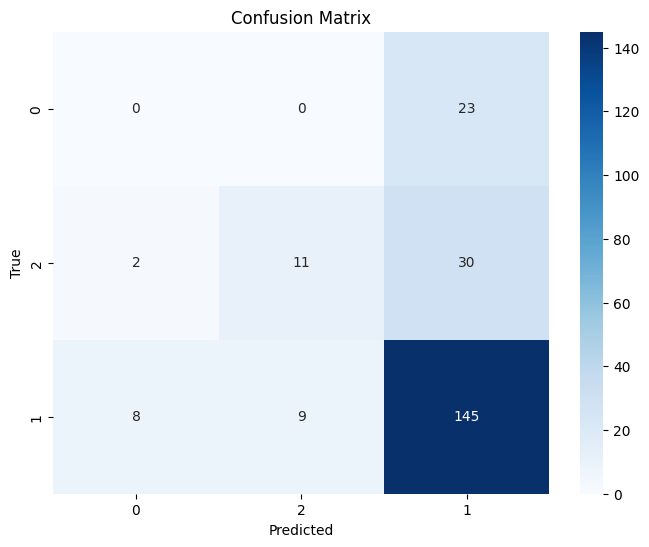

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 혼동 행렬을 계산하고 시각화하는 함수
def plot_confusion_matrix(model, valid_loader, classes):
    model.eval()  # 모델을 평가 모드로 설정
    all_preds = []
    all_labels = []

    # 검증 데이터셋에 대한 예측값 수집
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())  # 예측값을 리스트에 추가
            all_labels.extend(labels.cpu().numpy())    # 실제 라벨을 리스트에 추가

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬을 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 클래스 목록을 제공해야 함 (ex. ['Very Dry', 'Dry', 'Normal', ...])
classes = train_dataset.classes  # train_dataset에서 클래스 이름 가져오기

# 혼동 행렬 출력
plot_confusion_matrix(model, valid_loader, classes)


Epoch 1/30: 100%|██████████| 116/116 [00:44<00:00,  2.60it/s, loss=0.91]


Epoch 1/30, Loss: 0.9099701180540282, Train Accuracy: 38.14655172413793%
Validation Accuracy: 12.280701754385966%


Epoch 2/30: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s, loss=0.726]


Epoch 2/30, Loss: 0.7257636957641306, Train Accuracy: 46.44396551724138%
Validation Accuracy: 21.49122807017544%


Epoch 3/30: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s, loss=0.578]


Epoch 3/30, Loss: 0.5775227739379324, Train Accuracy: 55.872844827586206%
Validation Accuracy: 22.80701754385965%


Epoch 4/30: 100%|██████████| 116/116 [00:44<00:00,  2.61it/s, loss=0.474]


Epoch 4/30, Loss: 0.473722574525866, Train Accuracy: 58.51293103448276%
Validation Accuracy: 22.36842105263158%


Epoch 5/30: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s, loss=0.391]


Epoch 5/30, Loss: 0.3910504210868786, Train Accuracy: 62.230603448275865%
Validation Accuracy: 24.12280701754386%


Epoch 6/30: 100%|██████████| 116/116 [00:44<00:00,  2.63it/s, loss=0.32]


Epoch 6/30, Loss: 0.3199401583907933, Train Accuracy: 64.65517241379311%
Validation Accuracy: 25.43859649122807%


Epoch 7/30: 100%|██████████| 116/116 [00:44<00:00,  2.61it/s, loss=0.276]


Epoch 7/30, Loss: 0.2758778065186122, Train Accuracy: 65.78663793103448%
Validation Accuracy: 25.0%


Epoch 8/30: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s, loss=0.249]


Epoch 8/30, Loss: 0.24873847135439, Train Accuracy: 68.91163793103448%
Validation Accuracy: 26.31578947368421%


Epoch 9/30: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s, loss=0.265]


Epoch 9/30, Loss: 0.26472316354770087, Train Accuracy: 69.66594827586206%
Validation Accuracy: 29.82456140350877%


Epoch 10/30: 100%|██████████| 116/116 [00:44<00:00,  2.58it/s, loss=0.203]


Epoch 10/30, Loss: 0.20320254101835447, Train Accuracy: 72.2521551724138%
Validation Accuracy: 30.263157894736842%


Epoch 11/30: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s, loss=0.193]


Epoch 11/30, Loss: 0.19347282023779278, Train Accuracy: 73.76077586206897%
Validation Accuracy: 32.01754385964912%


Epoch 12/30: 100%|██████████| 116/116 [00:44<00:00,  2.61it/s, loss=0.201]


Epoch 12/30, Loss: 0.20090818347345138, Train Accuracy: 75.0%
Validation Accuracy: 34.21052631578947%


Epoch 13/30: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s, loss=0.179]


Epoch 13/30, Loss: 0.17920061059553047, Train Accuracy: 75.64655172413794%
Validation Accuracy: 34.21052631578947%


Epoch 14/30: 100%|██████████| 116/116 [00:44<00:00,  2.60it/s, loss=0.169]


Epoch 14/30, Loss: 0.16924199911540952, Train Accuracy: 78.66379310344827%
Validation Accuracy: 32.89473684210526%


Epoch 15/30: 100%|██████████| 116/116 [00:44<00:00,  2.61it/s, loss=0.171]


Epoch 15/30, Loss: 0.17059161754903093, Train Accuracy: 77.96336206896552%
Validation Accuracy: 38.1578947368421%


Epoch 16/30: 100%|██████████| 116/116 [00:45<00:00,  2.57it/s, loss=0.158]


Epoch 16/30, Loss: 0.158224165792866, Train Accuracy: 79.52586206896552%
Validation Accuracy: 47.36842105263158%


Epoch 17/30: 100%|██████████| 116/116 [00:44<00:00,  2.58it/s, loss=0.154]


Epoch 17/30, Loss: 0.15386861808405355, Train Accuracy: 80.38793103448276%
Validation Accuracy: 42.98245614035088%


Epoch 18/30: 100%|██████████| 116/116 [00:44<00:00,  2.60it/s, loss=0.139]


Epoch 18/30, Loss: 0.13867040254689497, Train Accuracy: 82.32758620689656%
Validation Accuracy: 43.421052631578945%


Epoch 19/30: 100%|██████████| 116/116 [00:45<00:00,  2.57it/s, loss=0.141]


Epoch 19/30, Loss: 0.14080005895410633, Train Accuracy: 83.83620689655173%
Validation Accuracy: 43.85964912280702%


Epoch 20/30: 100%|██████████| 116/116 [00:44<00:00,  2.60it/s, loss=0.138]


Epoch 20/30, Loss: 0.13803623199205975, Train Accuracy: 82.65086206896552%
Validation Accuracy: 47.80701754385965%


Epoch 21/30: 100%|██████████| 116/116 [00:44<00:00,  2.61it/s, loss=0.119]


Epoch 21/30, Loss: 0.11936792378024809, Train Accuracy: 85.18318965517241%
Validation Accuracy: 43.421052631578945%


Epoch 22/30: 100%|██████████| 116/116 [00:45<00:00,  2.57it/s, loss=0.117]


Epoch 22/30, Loss: 0.11729010595972168, Train Accuracy: 84.48275862068965%
Validation Accuracy: 47.36842105263158%


Epoch 23/30: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s, loss=0.103]


Epoch 23/30, Loss: 0.10258678411101473, Train Accuracy: 88.09267241379311%
Validation Accuracy: 45.6140350877193%


Epoch 24/30: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s, loss=0.117]


Epoch 24/30, Loss: 0.11703825794995346, Train Accuracy: 85.82974137931035%
Validation Accuracy: 50.43859649122807%


Epoch 25/30: 100%|██████████| 116/116 [00:45<00:00,  2.56it/s, loss=0.103]


Epoch 25/30, Loss: 0.10257319964725396, Train Accuracy: 87.1228448275862%
Validation Accuracy: 53.07017543859649%


Epoch 26/30: 100%|██████████| 116/116 [00:44<00:00,  2.60it/s, loss=0.0973]


Epoch 26/30, Loss: 0.09733792259518442, Train Accuracy: 88.41594827586206%
Validation Accuracy: 51.75438596491228%


Epoch 27/30: 100%|██████████| 116/116 [00:44<00:00,  2.61it/s, loss=0.105]


Epoch 27/30, Loss: 0.10495618592690804, Train Accuracy: 87.8771551724138%
Validation Accuracy: 48.68421052631579%


Epoch 28/30: 100%|██████████| 116/116 [00:44<00:00,  2.58it/s, loss=0.0936]


Epoch 28/30, Loss: 0.09364454361513772, Train Accuracy: 89.22413793103448%
Validation Accuracy: 50.87719298245614%


Epoch 29/30: 100%|██████████| 116/116 [00:44<00:00,  2.60it/s, loss=0.087]


Epoch 29/30, Loss: 0.08697010168869948, Train Accuracy: 89.92456896551724%
Validation Accuracy: 50.87719298245614%


Epoch 30/30: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s, loss=0.0832]


Epoch 30/30, Loss: 0.08319617781370621, Train Accuracy: 90.625%
Validation Accuracy: 53.50877192982456%


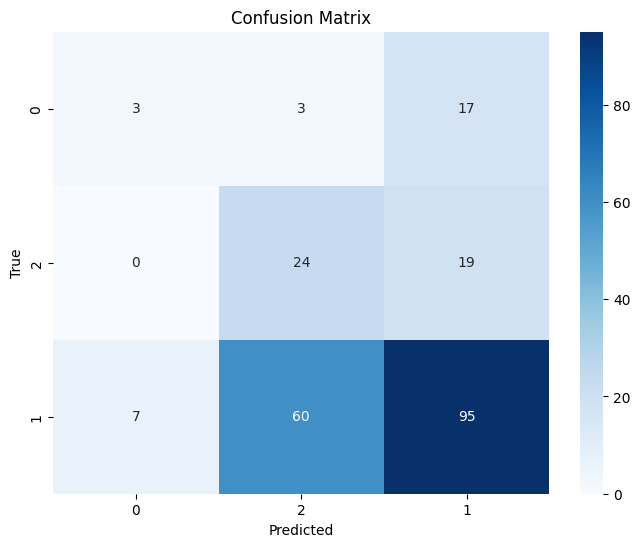

In [8]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []

        for label in range(len(self.classes)):
            class_folder = os.path.join(root_dir, self.classes[label])
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지 RGB로 변환
        if self.transform:
            image = self.transform(image)
        return image, label

# 경로 및 배치 크기 설정
base_dir = '/content/uploadfolder'  # 베이스 경로
batch_size = 16

# 사용할 데이터 선택 (오른볼, 왼볼, 이마 중 하나 선택)
data_dir = os.path.join(base_dir, '오른볼 최종')  # 예시: '오른볼 최종' 사용

# 데이터 증강 포함한 이미지 전처리
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),  # 더 큰 회전 각도
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이미지 이동
    T.GaussianBlur(kernel_size=3),  # Gaussian Blur 추가
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 학습 및 검증 데이터셋 생성
train_dataset = CustomDataset(os.path.join(data_dir, '오른볼train'), transform=transform)
valid_dataset = CustomDataset(os.path.join(data_dir, '오른볼valid'), transform=transform)

# 각 클래스의 데이터 개수 계산 (Counter 사용)
class_counts = Counter([label for _, label in train_dataset])

# 클래스별로 가중치를 부여 (데이터 개수의 역수 사용)
class_weights = torch.tensor([1.0 / class_counts[cls] for cls in sorted(class_counts)], dtype=torch.float).to(device)

# 손실 함수에서 가중치 적용
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# 각 샘플의 가중치를 리스트로 변환
sample_weights = [class_weights[label] for _, label in train_dataset]

# WeightedRandomSampler 생성
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

# WeightedRandomSampler를 적용한 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 사전 학습된 resnext50_32x4d 모델 사용
from torchvision.models import ResNeXt50_32X4D_Weights

weights = ResNeXt50_32X4D_Weights.DEFAULT
model = models.resnext50_32x4d(weights=weights)

# 모든 레이어 학습 가능하도록 설정 (전이 학습 제외)
for param in model.parameters():
    param.requires_grad = True

# 출력 레이어를 분류하려는 클래스 수에 맞게 수정 (드롭아웃 비율 0.4으로 조정)
model.fc = nn.Sequential(
    nn.Dropout(0.4),  # 드롭아웃을 늘려서 과적합 방지
    nn.Linear(model.fc.in_features, len(train_dataset.classes))
)

model.to(device)  # 모델을 GPU/CPU에 올리기

# best_accuracy 초기화
best_accuracy = 0.0  # 가장 높은 검증 정확도를 기록할 변수

# Early Stopping 설정
patience = 5  # 개선되지 않는 에포크를 허용하는 최대 수
counter = 0

# 손실 함수 및 AdamW 옵티마이저 설정 (학습률 0.0001로 감소)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005)

# 학습률 스케줄러 추가 (학습률 점진적 감소, gamma=0.5, step_size=5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# 학습 과정 (TQDM으로 진행 상황 시각화, 에포크 30)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # TQDM으로 학습 진행 표시
    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in train_loader_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_iter.set_postfix(loss=running_loss / len(train_loader))

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}%")

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 평가
    model.eval()
    correct_valid = 0
    total_valid = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())  # 예측 값 저장
            all_labels.extend(labels.cpu().numpy())    # 실제 값 저장

    valid_accuracy = 100 * correct_valid / total_valid
    print(f'Validation Accuracy: {valid_accuracy}%')

    # Early Stopping 기준
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy  # 최적의 정확도 업데이트
        counter = 0  # 성능 개선 시 카운터 초기화
        torch.save(model.state_dict(), 'best_model.pth')  # 최적의 모델 저장
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping 적용")
            break

# 혼동 행렬 계산 및 시각화
def plot_confusion_matrix(all_labels, all_preds, classes):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 클래스 목록을 제공 (예시: ['Very Dry', 'Dry', 'Normal', ...])
classes = train_dataset.classes

# 혼동 행렬 출력
plot_confusion_matrix(all_labels, all_preds, classes)
